In [1]:
import pandas as pd
import pyarrow.parquet as pq
import os
import numpy as np

os.chdir('./dataset')

In [2]:
for m in range(1,13):
            
    #load data from ./dataset for 2022
    fileDate=('2022'+'-'+str("{:02d}".format(m)))       
    fileName='fhvhv_tripdata_'+fileDate+'.parquet'
    fileDateName=('2022'+'_'+str("{:02d}".format(m)))  
    globals()["trips" + fileDateName] = pq.read_table(fileName).to_pandas() 
    
    #filter for uber
    globals()["trips" + fileDateName] = globals()["trips" + fileDateName].drop(
                                            globals()["trips" + fileDateName][
                                                globals()["trips" + fileDateName].hvfhs_license_num  != 'HV0003'
                                            ].index)
         
    #drop all columns which are not required 
    globals()["trips" + fileDateName] = globals()["trips" + fileDateName].drop([
        'shared_request_flag', 
        'shared_match_flag', 
        'access_a_ride_flag',
        'wav_request_flag',
        'wav_match_flag'], axis=1)
    
    #add column month 
    globals()["trips" + fileDateName].insert(0,"month",m)
    
    #sample size 10,000 for every month
    globals()["trips" + fileDateName] = globals()["trips" + fileDateName].sample(n=10000)


In [3]:
df_list = [trips2022_01, trips2022_02, trips2022_03, trips2022_04, trips2022_05, trips2022_06, 
           trips2022_07, trips2022_08, trips2022_09, trips2022_10, trips2022_11, trips2022_12] 
    
df_uber_2022 = pd.concat(df_list)  
df_uber_2022.to_csv('/Users/KaySimon_1/Desktop/df_uber_2022.csv')

In [2]:
df = pd.read_csv('/Users/KaySimon_1/Desktop/df_uber_2022.csv')
df = df.drop(['Unnamed: 0','hvfhs_license_num', 'dispatching_base_num', 'originating_base_num', 'dropoff_datetime','tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay'], axis = 1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                120000 non-null  int64  
 1   request_datetime     120000 non-null  object 
 2   on_scene_datetime    120000 non-null  object 
 3   pickup_datetime      120000 non-null  object 
 4   PULocationID         120000 non-null  int64  
 5   DOLocationID         120000 non-null  int64  
 6   trip_miles           120000 non-null  float64
 7   trip_time            120000 non-null  int64  
 8   base_passenger_fare  120000 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 8.2+ MB


# Merging separate dataframe taxizone

In [4]:
taxi_zone = pd.read_csv('taxi_zone_lookup.csv')

In [5]:
#delete taxi zone 1 (EWR), 264 (Unknown), 265 (Unknown)
df = df.drop(df[df['PULocationID'] == 1].index)
df = df.drop(df[df['PULocationID'] == 264].index)
df = df.drop(df[df['PULocationID'] == 265].index)
df = df.drop(df[df['DOLocationID'] == 1].index)
df = df.drop(df[df['DOLocationID'] == 264].index)
df = df.drop(df[df['DOLocationID'] == 265].index)

In [6]:
#merge df and taxi_zone based on PULocationID and DOLocationID
df['taxi_zone_start_location'] = df['PULocationID']
df['taxi_zone_end_location'] = df['DOLocationID']
df[['taxi_zone_start_location', 'taxi_zone_end_location']] = df[['taxi_zone_start_location', 'taxi_zone_end_location']].replace(taxi_zone.set_index('LocationID')['Borough'])
df['StartLoc_EndLoc'] = df['taxi_zone_start_location'] + df['taxi_zone_end_location']
df = df.drop(['taxi_zone_start_location', 'taxi_zone_end_location'], axis = 1)

# Merging Weather Dataset 2022 NYC NOAA

##### column selection
DATE - date
SNOW - Snowfall
SNWD - Snow depth
AWND - Average wind speed
WT01 - Fog, ice fog, or freezing fog (may include heavy fog)
TMAX - Maximum temperature
TMIN - Minimum temperature
PRCP - Precipitation

In [7]:
df_temp_2022 = pd.read_csv('nyc_weather_data_2022.csv')

In [8]:
selected_columns = ['DATE', 'SNOW', 'SNWD', 'AWND', 'WT01', 'TMAX', 'TMIN', 'PRCP']
df_temp_2022 = df_temp_2022[selected_columns]
df_temp_2022['DATE'] = pd.to_datetime(df_temp_2022['DATE']).dt.date
df_temp_2022 = df_temp_2022.rename(columns={'DATE': 'merge_column_date'})

In [9]:
df_temp_2022.isna().sum()

merge_column_date      0
SNOW                   0
SNWD                   0
AWND                   0
WT01                 236
TMAX                   0
TMIN                   0
PRCP                   0
dtype: int64

In [10]:
# fill in missing values with 0 since it is a dummy variable
df_temp_2022['WT01'] = df_temp_2022['WT01'].fillna(0)

In [11]:
#create column in main dataframe to prepare the merge
df['merge_column_date'] = pd.to_datetime(df['on_scene_datetime']).dt.date

In [12]:
#perform left join
df = df.merge(df_temp_2022, on='merge_column_date', how ="left")

In [13]:
# drop merge helper column
df = df.drop(['merge_column_date'], axis = 1)

# Data cleaning

In [14]:
#create day_of_week
df['day_of_week'] = pd.to_datetime(df['pickup_datetime'])
df['day_of_week'] = df['day_of_week'].dt.dayofweek

In [15]:
#converting datetime objects to seconds
df['request_datetime'] = pd.to_datetime(df['request_datetime'])
df['request_datetime'] = df['request_datetime'].astype(int) / 10**9

df['on_scene_datetime'] = pd.to_datetime(df['on_scene_datetime'])
df['on_scene_datetime'] = df['on_scene_datetime'].astype(int) / 10**9

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_datetime'] = df['pickup_datetime'].astype(int) / 10**9

In [16]:
#feature creation
df['waiting_time'] = df['on_scene_datetime'] - df['request_datetime']

df['miles/second'] = df['trip_miles'] / df['trip_time']

df['weekend'] = 0
df.loc[(df['day_of_week'] == 5) | (df['day_of_week'] == 6), 'weekend'] = 1

In [17]:
#creating one weather condition column (hot or cold)
df['Hot'] = np.where(df['TMAX']>=80, 1, 0) 
df['Cold'] = np.where(df['TMIN']<30, 1, 0)

In [18]:
# check changes
df.head()

,month,request_datetime,on_scene_datetime,pickup_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,StartLoc_EndLoc,...,WT01,TMAX,TMIN,PRCP,day_of_week,waiting_time,miles/second,weekend,Hot,Cold
0,1,1.643268e+09,1.643268e+09,1.643268e+09,255,195,6.01,1109,26.25,BrooklynBrooklyn,...,0.0,32,17,0.00,3,318.0,0.005419,0,0,1
1,1,1.643062e+09,1.643063e+09,1.643063e+09,234,107,1.83,673,21.39,ManhattanManhattan,...,0.0,36,26,0.00,0,184.0,0.002719,0,0,1
2,1,1.641377e+09,1.641377e+09,1.641377e+09,140,145,3.07,665,13.33,ManhattanQueens,...,1.0,47,31,0.23,2,33.0,0.004617,0,0,0
3,1,1.642505e+09,1.642505e+09,1.642505e+09,159,244,4.66,1375,21.30,BronxManhattan,...,0.0,36,29,0.00,1,92.0,0.003389,0,0,1
4,1,1.642952e+09,1.642951e+09,1.642951e+09,163,140,1.04,551,9.23,ManhattanManhattan,...,1.0,37,24,0.02,6,-629.0,0.001887,1,0,1


# Standard Scaler

In [19]:
# split categorial and numerical columns before feature scaling
category = pd.DataFrame(df['StartLoc_EndLoc'])
numerical = df.drop(['StartLoc_EndLoc'], axis = 1)

In [20]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(numerical)
numerical_scaled = scaler.transform(numerical)

In [21]:
numerical_scaled

array([[-1.58770272, -1.47047758, -1.47046621, ..., -0.67760328,
        -0.56651028,  2.23233476],
       [-1.58770272, -1.4930047 , -1.49300801, ..., -0.67760328,
        -0.56651028,  2.23233476],
       [-1.58770272, -1.67804831, -1.67806799, ..., -0.67760328,
        -0.56651028, -0.44796149],
       ...,
       [ 1.59636675,  1.5592658 ,  1.55928607, ..., -0.67760328,
        -0.56651028,  2.23233476],
       [ 1.59636675,  1.48944209,  1.48945706, ..., -0.67760328,
        -0.56651028, -0.44796149],
       [ 1.59636675,  1.48211726,  1.48210984, ...,  1.47578978,
        -0.56651028, -0.44796149]])

# One Hot Encoder

In [22]:
# perform one hot encoder on categorial columns (df['StartLoc_EndLoc'])
from sklearn.preprocessing import OneHotEncoder

location_encoder = OneHotEncoder()
location_cat_1hot = location_encoder.fit_transform(category)

In [23]:
print(location_cat_1hot.toarray())
location_encoder.categories_

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[array(['BronxBronx', 'BronxBrooklyn', 'BronxManhattan', 'BronxQueens',
        'BronxStaten Island', 'BrooklynBronx', 'BrooklynBrooklyn',
        'BrooklynManhattan', 'BrooklynQueens', 'BrooklynStaten Island',
        'ManhattanBronx', 'ManhattanBrooklyn', 'ManhattanManhattan',
        'ManhattanQueens', 'ManhattanStaten Island', 'QueensBronx',
        'QueensBrooklyn', 'QueensManhattan', 'QueensQueens',
        'QueensStaten Island', 'Staten IslandBronx',
        'Staten IslandBrooklyn', 'Staten IslandManhattan',
        'Staten IslandQueens', 'Staten IslandStaten Island'], dtype=object)]

In [24]:
# transform one hot encoded array back to dataframe
location_cat_1hot_array = location_cat_1hot.toarray()
encoded_df = pd.DataFrame(location_cat_1hot_array, columns=location_encoder.get_feature_names_out(['StartLoc_EndLoc']))

In [25]:
#reset all indexes before concat
df = df.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)
# concat encoded location category to main dataset 
df = pd.concat([df, encoded_df], axis=1)
df

,month,request_datetime,on_scene_datetime,pickup_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,StartLoc_EndLoc,...,StartLoc_EndLoc_QueensBronx,StartLoc_EndLoc_QueensBrooklyn,StartLoc_EndLoc_QueensManhattan,StartLoc_EndLoc_QueensQueens,StartLoc_EndLoc_QueensStaten Island,StartLoc_EndLoc_Staten IslandBronx,StartLoc_EndLoc_Staten IslandBrooklyn,StartLoc_EndLoc_Staten IslandManhattan,StartLoc_EndLoc_Staten IslandQueens,StartLoc_EndLoc_Staten IslandStaten Island
0,1,1.643268e+09,1.643268e+09,1.643268e+09,255,195,6.01,1109,26.25,BrooklynBrooklyn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.643062e+09,1.643063e+09,1.643063e+09,234,107,1.83,673,21.39,ManhattanManhattan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1.641377e+09,1.641377e+09,1.641377e+09,140,145,3.07,665,13.33,ManhattanQueens,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1.642505e+09,1.642505e+09,1.642505e+09,159,244,4.66,1375,21.30,BronxManhattan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1.642952e+09,1.642951e+09,1.642951e+09,163,140,1.04,551,9.23,ManhattanManhattan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114055,12,1.670515e+09,1.670515e+09,1.670515e+09,63,258,0.65,295,7.91,BrooklynQueens,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114056,12,1.670190e+09,1.670190e+09,1.670190e+09,36,225,1.71,645,11.55,BrooklynBrooklyn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114057,12,1.670866e+09,1.670866e+09,1.670866e+09,197,63,6.32,1054,23.18,QueensBrooklyn,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114058,12,1.670230e+09,1.670230e+09,1.670230e+09,113,161,2.49,1070,29.62,ManhattanManhattan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# drop column 'StartLoc_EndLoc' since it is reflected as dummy variables(One Hot Encoder)
df = df.drop(['StartLoc_EndLoc'], axis = 1)

# Histograms

In [27]:
df.describe()

,month,request_datetime,on_scene_datetime,pickup_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,SNOW,...,StartLoc_EndLoc_QueensBronx,StartLoc_EndLoc_QueensBrooklyn,StartLoc_EndLoc_QueensManhattan,StartLoc_EndLoc_QueensQueens,StartLoc_EndLoc_QueensStaten Island,StartLoc_EndLoc_Staten IslandBronx,StartLoc_EndLoc_Staten IslandBrooklyn,StartLoc_EndLoc_Staten IslandManhattan,StartLoc_EndLoc_Staten IslandQueens,StartLoc_EndLoc_Staten IslandStaten Island
count,114060.000000,1.140600e+05,1.140600e+05,1.140600e+05,114060.000000,114060.000000,114060.000000,114060.000000,114060.000000,114060.000000,...,114060.000000,114060.000000,114060.000000,114060.000000,114060.000000,114060.000000,114060.000000,114060.000000,114060.000000,114060.000000
mean,6.485034,1.656662e+09,1.656663e+09,1.656663e+09,139.635166,139.429204,4.455442,1110.201447,22.221457,0.047468,...,0.004349,0.024855,0.033123,0.124882,0.000228,0.000035,0.000938,0.000438,0.000228,0.011091
std,3.454714,9.109195e+06,9.109205e+06,9.109204e+06,75.066868,74.317996,4.376372,766.899545,15.987317,0.476562,...,0.065801,0.155685,0.178958,0.330586,0.015096,0.005922,0.030614,0.020933,0.015096,0.104727
min,1.000000,1.640995e+09,1.640995e+09,1.640995e+09,3.000000,3.000000,0.000000,5.000000,-19.550000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.648735e+09,1.648735e+09,1.648735e+09,76.000000,76.000000,1.560000,581.000000,11.350000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,1.656589e+09,1.656589e+09,1.656589e+09,141.000000,140.000000,2.840000,916.000000,17.940000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,1.664563e+09,1.664563e+09,1.664564e+09,211.000000,210.000000,5.700000,1426.000000,27.990000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,1.672531e+09,1.672531e+09,1.672531e+09,263.000000,263.000000,133.670000,35113.000000,1220.360000,7.300000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
# correlation between other features and base_passenger_fare
corr_matrix = df.corr()
corr_matrix['base_passenger_fare'].sort_values(ascending=False)

base_passenger_fare                           1.000000
trip_time                                     0.820982
trip_miles                                    0.801601
miles/second                                  0.400560
StartLoc_EndLoc_ManhattanQueens               0.316937
StartLoc_EndLoc_QueensManhattan               0.228215
StartLoc_EndLoc_ManhattanBrooklyn             0.151231
StartLoc_EndLoc_BrooklynManhattan             0.129186
StartLoc_EndLoc_BrooklynQueens                0.128540
StartLoc_EndLoc_QueensBrooklyn                0.098831
waiting_time                                  0.095801
StartLoc_EndLoc_BronxBrooklyn                 0.082425
StartLoc_EndLoc_BrooklynBronx                 0.080982
StartLoc_EndLoc_ManhattanStaten Island        0.074830
StartLoc_EndLoc_BronxQueens                   0.073950
StartLoc_EndLoc_QueensBronx                   0.065109
pickup_datetime                               0.064834
on_scene_datetime                             0.064833
request_da

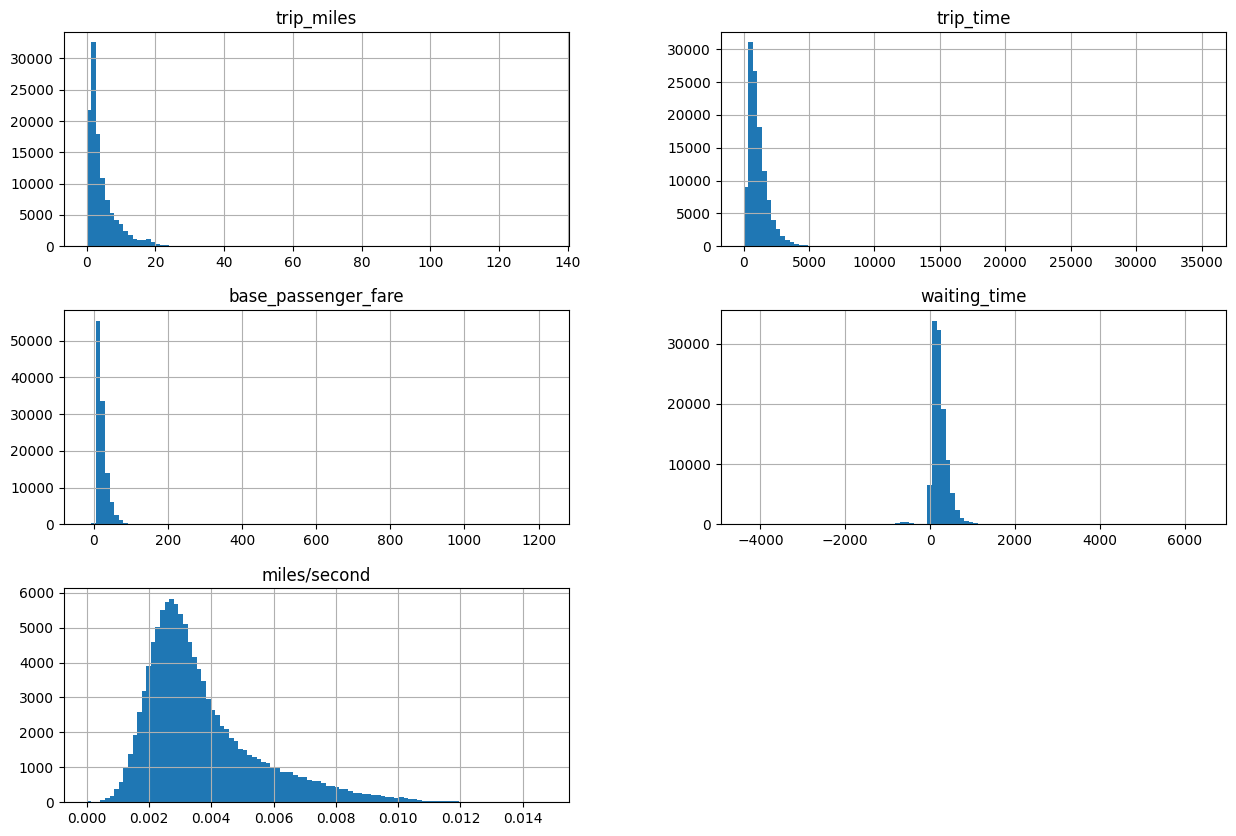

In [29]:
# plot promising histograms
import matplotlib.pyplot as plt

columns_to_plot=['trip_miles','trip_time','base_passenger_fare','waiting_time','miles/second']
df[columns_to_plot].hist(bins=100,figsize=(15,10))
plt.show()

array([[<Axes: xlabel='base_passenger_fare', ylabel='base_passenger_fare'>,
        <Axes: xlabel='trip_miles', ylabel='base_passenger_fare'>,
        <Axes: xlabel='trip_time', ylabel='base_passenger_fare'>,
        <Axes: xlabel='miles/second', ylabel='base_passenger_fare'>],
       [<Axes: xlabel='base_passenger_fare', ylabel='trip_miles'>,
        <Axes: xlabel='trip_miles', ylabel='trip_miles'>,
        <Axes: xlabel='trip_time', ylabel='trip_miles'>,
        <Axes: xlabel='miles/second', ylabel='trip_miles'>],
       [<Axes: xlabel='base_passenger_fare', ylabel='trip_time'>,
        <Axes: xlabel='trip_miles', ylabel='trip_time'>,
        <Axes: xlabel='trip_time', ylabel='trip_time'>,
        <Axes: xlabel='miles/second', ylabel='trip_time'>],
       [<Axes: xlabel='base_passenger_fare', ylabel='miles/second'>,
        <Axes: xlabel='trip_miles', ylabel='miles/second'>,
        <Axes: xlabel='trip_time', ylabel='miles/second'>,
        <Axes: xlabel='miles/second', ylabel='miles

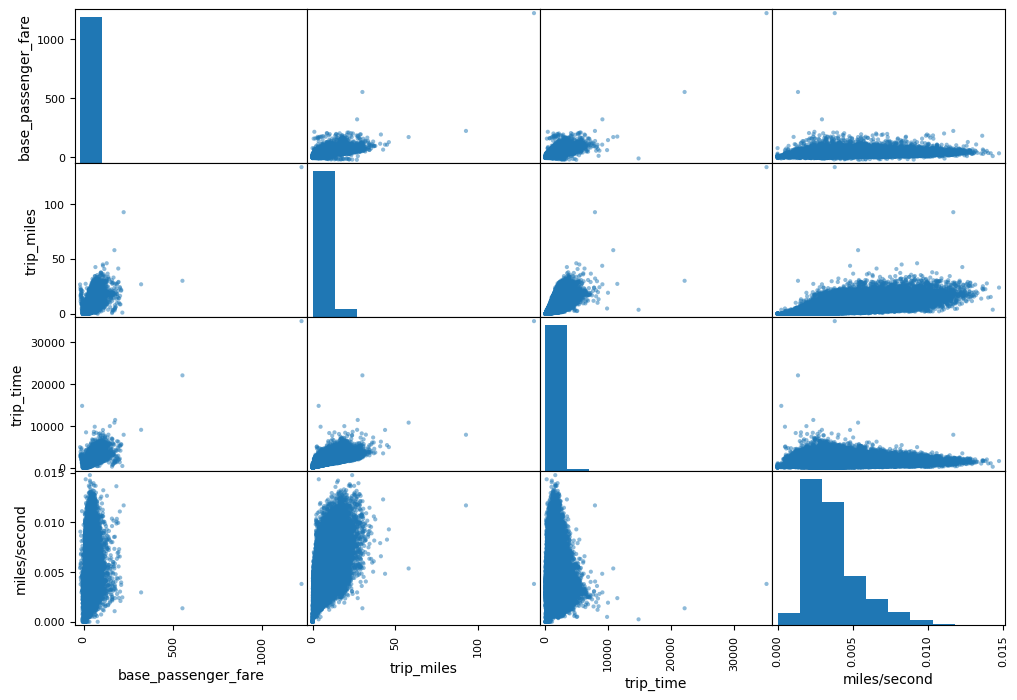

In [30]:
#plot scatter matrix to visualize correlations
from pandas.plotting import scatter_matrix

attributes=['base_passenger_fare','trip_miles','trip_time','miles/second']
scatter_matrix(df[attributes],figsize=(12,8))

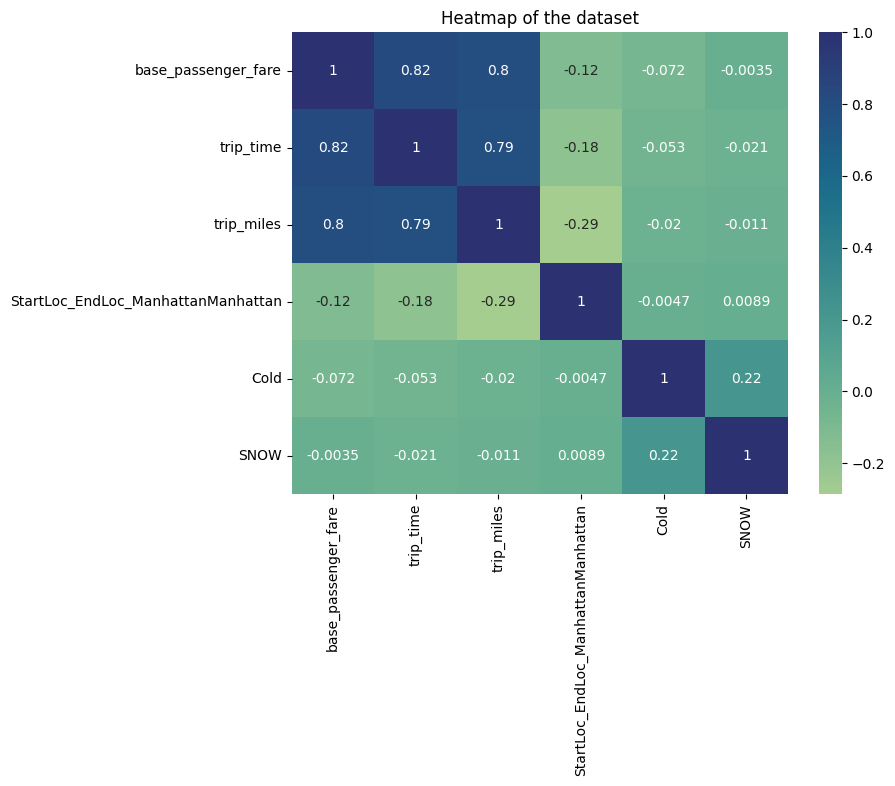

In [31]:
#correlation heatmap of some features
import seaborn as sns

plt.figure(figsize=(8, 6)) 
sns.heatmap(
    df[["base_passenger_fare", "trip_time", "trip_miles","StartLoc_EndLoc_ManhattanManhattan", "Cold", "SNOW"]]
    .corr(numeric_only=True), annot=True, cmap="crest"
)

plt.title("Heatmap of the dataset")
plt.show()

# Split Test and Train data set

In [32]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=69)

# Prepare for Modeling

In [33]:
# separate y, x values for models
y_train_set = train_set['base_passenger_fare']
x_train_set = train_set.drop(['base_passenger_fare'], axis=1)

In [62]:
df.shape

(114060, 47)

# Linear Regression

In [34]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train_set, y_train_set)

LinearRegression()

In [35]:
#calculate root mean squared error of linear regression
from sklearn.metrics import mean_squared_error

y_predict = lin_reg.predict(x_train_set)
lin_rmse = mean_squared_error(y_train_set, y_predict, squared=False)
lin_rmse

7.800433001883389

In [47]:
from sklearn.metrics import r2_score
r2_score(y_train_set, y_predict)

0.7621192629624471

# Decision Tree

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=69)
tree_reg.fit(x_train_set, y_train_set)

DecisionTreeRegressor(random_state=69)

In [37]:
#calculate root mean squared error of decision tree
y_predict_tree = tree_reg.predict(x_train_set)
tree_rmse = mean_squared_error(y_train_set, y_predict_tree, squared=False)
tree_rmse

6.174585865361495e-17

In [48]:
r2_score(y_train_set, y_predict_tree)

1.0

# Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators = 100,random_state = 69)
forest_reg.fit(x_train_set, y_train_set)

RandomForestRegressor(random_state=69)

In [39]:
#calculate root mean squared error of random forest
y_predict_forest = forest_reg.predict(x_train_set)
forest_rmse = mean_squared_error(y_train_set, y_predict_forest, squared=False)
forest_rmse

3.175652719641055

In [49]:
r2_score(y_train_set, y_predict_forest)

0.9605735331924042

# Cross-Validation

In [40]:
from sklearn.model_selection import cross_val_score

#cross-validation linear regression
linear_scores = cross_val_score(lin_reg, x_train_set, y_train_set,
                         scoring="neg_mean_squared_error", cv=10)
linear_rmse_scores = np.sqrt(-linear_scores)

In [41]:
#cross-validation decision tree
tree_scores = cross_val_score(tree_reg, x_train_set, y_train_set,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [42]:
#cross-validation random forest
forest_scores = cross_val_score(forest_reg, x_train_set, y_train_set,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [43]:
#display cross-validation rmse results
def display_scores(scores):
    print("Scores:", scores)
    print("RMSE-Mean:", scores.mean())
    print("RMSE-Standard deviation:", scores.std())

display_scores(linear_rmse_scores)
display_scores(tree_rmse_scores)
display_scores(forest_rmse_scores)

Scores: [ 7.35597854 10.77982049  7.49036558  7.05060391  7.37966936  7.823005
  8.20155643  7.52664618  6.88700286  7.13433091]
RMSE-Mean: 7.762897926522525
RMSE-Standard deviation: 1.0681780575644158
Scores: [14.96461719 16.28164187 10.53580486 10.7326927  11.14217175 11.61694995
 11.53224378 10.35687611 10.61641308 10.6669879 ]
RMSE-Mean: 11.844639917750852
RMSE-Standard deviation: 1.9524974399155446
Scores: [ 8.73446126 14.04733508  7.67115463  7.13431102  7.43417724  7.93168626
  8.27740828  7.33815805  6.97375161  7.17601535]
RMSE-Mean: 8.271845876853034
RMSE-Standard deviation: 1.9949987093067572


# Randomized Search

In [53]:
#chosen randomized search over grid search due to computational limitations
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=100),
        'max_features': randint(low=1, high=6),
    }

forest_reg = RandomForestRegressor(random_state=69)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=10, scoring='neg_mean_squared_error', random_state=69)
rnd_search.fit(x_train_set, y_train_set)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=69),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x29cb18810>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x29ad87ad0>},
                   random_state=69, scoring='neg_mean_squared_error')

# Choose Best Model from Randomized Search

In [64]:
#check if best estimator random forest performs better than linear regression (RMSE:7.80)
rnd_search.best_estimator_

forest_reg_tuned = RandomForestRegressor(n_estimators = 50, max_features=5,random_state = 69)
forest_reg_tuned.fit(x_train_set, y_train_set)

#calculate root mean squared error of random forest
y_predict_forest_tuned = forest_reg_tuned.predict(x_train_set)
forest_rmse_tuned = mean_squared_error(y_train_set, y_predict_forest_tuned, squared=False)
forest_rmse_tuned

#cross-validation random forest
forest_scores_tuned = cross_val_score(forest_reg_tuned, x_train_set, y_train_set,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores_tuned = np.sqrt(-forest_scores)

In [65]:
print("Scores:", forest_rmse_scores_tuned)
print("RMSE-Mean:", forest_rmse_scores_tuned.mean())
print("RMSE-Standard deviation:", forest_rmse_scores_tuned.std())

Scores: [ 8.73446126 14.04733508  7.67115463  7.13431102  7.43417724  7.93168626
  8.27740828  7.33815805  6.97375161  7.17601535]
RMSE-Mean: 8.271845876853034
RMSE-Standard deviation: 1.9949987093067572


## Feature importance of random forest best_estimator

In [69]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([7.53364383e-03, 2.47364443e-02, 2.35687039e-02, 2.28608500e-02,
       1.92572409e-02, 2.12559769e-02, 2.67492159e-01, 3.29015537e-01,
       6.33046120e-04, 4.96618669e-04, 1.22727112e-02, 2.97998362e-03,
       1.22552147e-02, 1.25922753e-02, 7.22702923e-03, 8.76274122e-03,
       3.37170184e-02, 8.44181698e-02, 2.55859821e-03, 1.27256356e-03,
       1.06858918e-03, 9.83530370e-03, 1.40071087e-03, 7.93102151e-04,
       7.47148902e-04, 3.14367433e-06, 5.00030736e-04, 8.71431810e-03,
       5.89167430e-03, 2.67974851e-03, 7.97927734e-05, 7.11242299e-04,
       7.26862293e-03, 6.47129475e-03, 2.93184952e-02, 9.54668774e-04,
       4.76270720e-04, 1.53030506e-03, 1.59998983e-02, 7.78129533e-03,
       1.45657267e-03, 4.82935438e-05, 1.12084783e-04, 1.72228706e-04,
       2.55697881e-04, 8.22939809e-04])

In [70]:
#return coefficient (impact) of each feature on base_passenger_fare
feature_columns = list(x_train_set)
sorted_feature_importances = sorted(zip(feature_importances, feature_columns), reverse=True)
sorted_feature_importances

[(0.32901553705778713, 'trip_time'),
 (0.26749215948757804, 'trip_miles'),
 (0.08441816980014326, 'miles/second'),
 (0.03371701839474285, 'waiting_time'),
 (0.029318495164410114, 'StartLoc_EndLoc_ManhattanQueens'),
 (0.02473644433151213, 'request_datetime'),
 (0.02356870389746609, 'on_scene_datetime'),
 (0.022860850000509365, 'pickup_datetime'),
 (0.021255976919060147, 'DOLocationID'),
 (0.019257240897733553, 'PULocationID'),
 (0.015999898284748983, 'StartLoc_EndLoc_QueensManhattan'),
 (0.012592275267922436, 'TMIN'),
 (0.012272711187302467, 'AWND'),
 (0.012255214688986386, 'TMAX'),
 (0.009835303699003067, 'StartLoc_EndLoc_BronxBronx'),
 (0.00876274122375539, 'day_of_week'),
 (0.008714318100916904, 'StartLoc_EndLoc_BrooklynBrooklyn'),
 (0.007781295333847525, 'StartLoc_EndLoc_QueensQueens'),
 (0.007533643831007462, 'month'),
 (0.007268622933584388, 'StartLoc_EndLoc_ManhattanBrooklyn'),
 (0.007227029234763198, 'PRCP'),
 (0.006471294746371752, 'StartLoc_EndLoc_ManhattanManhattan'),
 (0.005

In [71]:
# Extracting sorted feature columns and scores for plotting
feature_columns = [item[1] for item in sorted_feature_importances]
feature_importances = [item[0] for item in sorted_feature_importances]

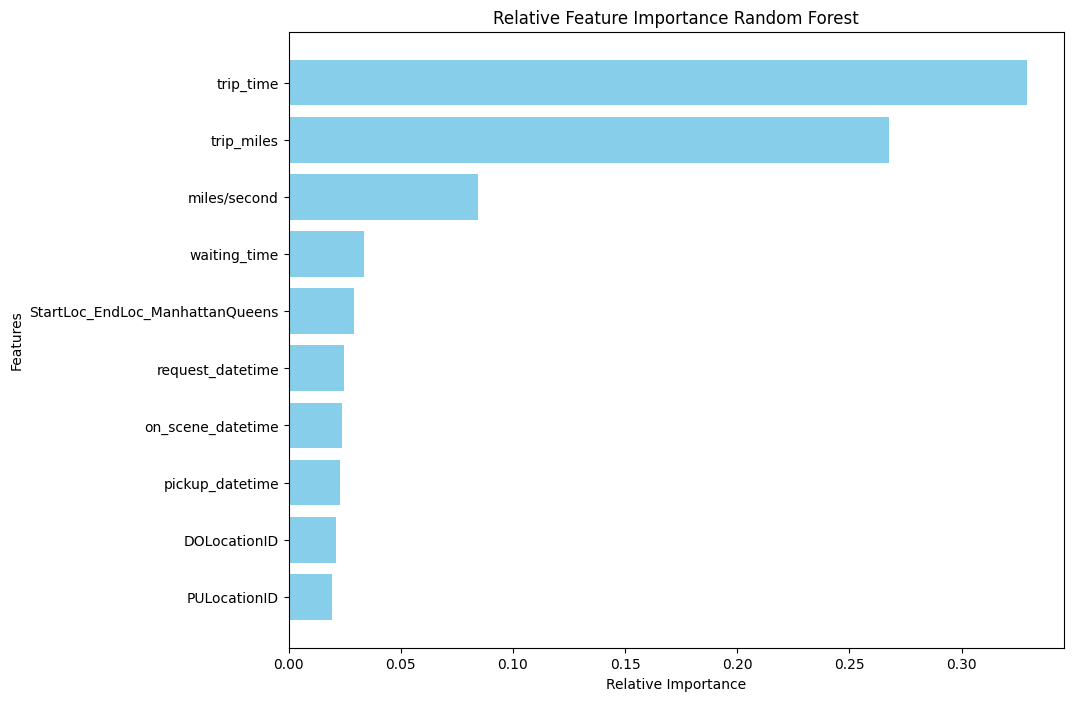

In [72]:
plt.figure(figsize=(10, 8))
plt.barh(feature_columns[:10], feature_importances[:10], color='skyblue')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Relative Feature Importance Random Forest')
plt.gca().invert_yaxis()

plt.show()

# Compare with Linear Regression Coefficients

In [50]:
lin_reg.coef_

array([-1.80714105e-01,  3.88252459e+04, -3.88252634e+04,  1.75256396e-02,
        2.09899713e-03,  1.93408655e-03,  1.51622754e+00,  9.64506057e-03,
        4.89434757e-01,  1.17278925e-01,  2.77707515e-02,  1.02784847e-01,
        9.36924951e-03,  1.39800680e-02,  4.62566534e-01,  2.23195403e-02,
        3.88252514e+04,  1.70743714e+02, -3.04652550e-02, -3.16616723e-01,
       -5.94250211e-01,  1.48258287e-01, -3.51652240e+00, -1.10447815e+00,
       -7.25185005e-01, -1.11993452e+01, -3.10387133e+00,  1.29229765e+00,
        2.65572462e+00,  1.83677601e+00, -1.29554306e+00,  8.79622290e-01,
        4.83062835e+00,  4.38925017e+00,  6.91833310e+00,  1.06826972e+01,
       -1.86837704e+00, -3.40031250e-01,  2.38831808e+00,  6.92243224e-01,
        6.56127246e+00, -1.24851849e+01, -4.09878117e+00, -1.60320566e+00,
       -2.15543851e+00,  2.20127118e-01])

In [52]:
#return coefficient (impact) of each feature on base_passenger_fare
feature_importance_lin_reg = lin_reg.coef_
feature_columns_lin_reg = list(x_train_set)
sorted_feature_importances_lin_reg = sorted(zip(feature_importance_lin_reg, feature_columns_lin_reg), reverse=True)
sorted_feature_importances_lin_reg

[(38825.25135203971, 'waiting_time'),
 (38825.245864251534, 'request_datetime'),
 (170.74371403376404, 'miles/second'),
 (10.682697199773722, 'StartLoc_EndLoc_ManhattanStaten Island'),
 (6.918333102599912, 'StartLoc_EndLoc_ManhattanQueens'),
 (6.561272461485331, 'StartLoc_EndLoc_QueensStaten Island'),
 (4.830628350425445, 'StartLoc_EndLoc_ManhattanBrooklyn'),
 (4.389250170035784, 'StartLoc_EndLoc_ManhattanManhattan'),
 (2.6557246222452733, 'StartLoc_EndLoc_BrooklynManhattan'),
 (2.388318082417217, 'StartLoc_EndLoc_QueensManhattan'),
 (1.8367760128196668, 'StartLoc_EndLoc_BrooklynQueens'),
 (1.516227537584071, 'trip_miles'),
 (1.292297650123012, 'StartLoc_EndLoc_BrooklynBrooklyn'),
 (0.8796222898784378, 'StartLoc_EndLoc_ManhattanBronx'),
 (0.692243223692429, 'StartLoc_EndLoc_QueensQueens'),
 (0.489434756533502, 'SNOW'),
 (0.46256653409598203, 'PRCP'),
 (0.22012711833649432, 'StartLoc_EndLoc_Staten IslandStaten Island'),
 (0.1482582873194085, 'StartLoc_EndLoc_BronxBronx'),
 (0.1172789245

In [66]:
# Extracting sorted feature columns and scores for plotting
feature_columns_lin = [item[1] for item in sorted_feature_importances_lin_reg]
feature_importances_lin = [item[0] for item in sorted_feature_importances_lin_reg]

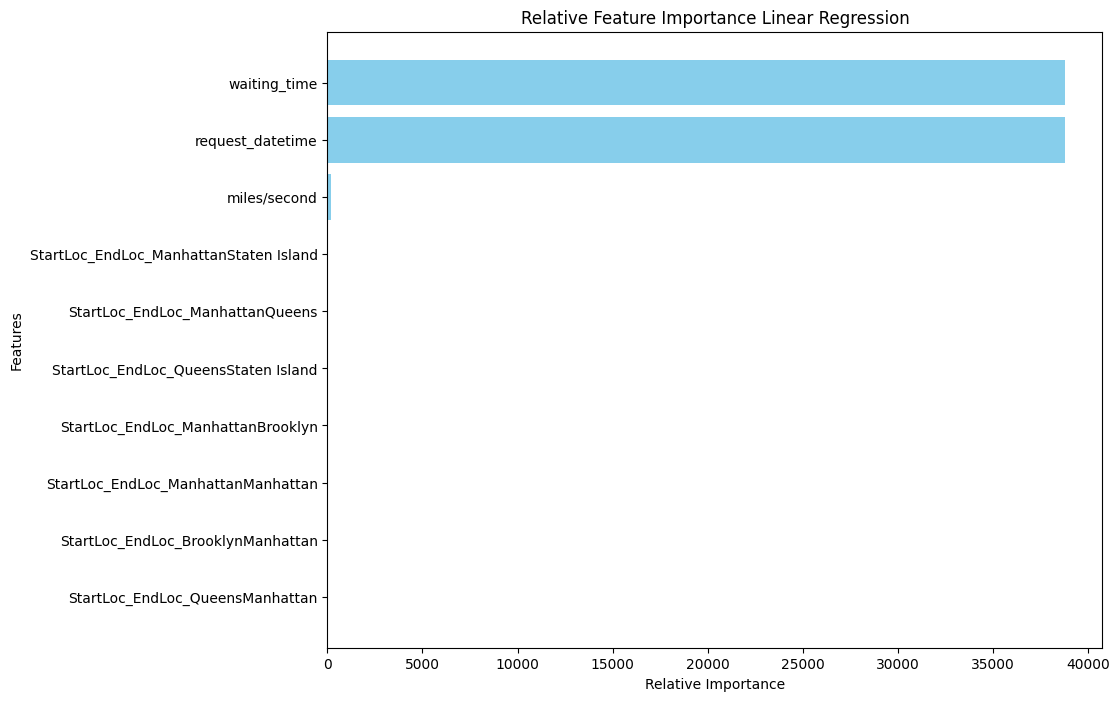

In [73]:
plt.figure(figsize=(10, 8))
plt.barh(feature_columns_lin[:10], feature_importances_lin[:10], color='skyblue')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Relative Feature Importance Linear Regression')
plt.gca().invert_yaxis()

plt.show()

Although linear regression does not overfit and exhibits slightly better performance than the Random Forest Regressor, we selected the Random Forest Regressor as our model due to the enhanced interpretability provided by its feature importance coefficients.

# Evaluate the model on test set

In [74]:
#split test_set into y and x value
y_test_set = test_set['base_passenger_fare']
x_test_set = test_set.drop(['base_passenger_fare'], axis=1)

In [75]:
#apply best estimator model of randomized search
final_model = rnd_search.best_estimator_

#predict y of x_text and calculate rmse 
y_predict_test = final_model.predict(x_test_set)
final_model_rmse = mean_squared_error(y_test_set, y_predict_test, squared=False)
final_model_rmse

7.918008729614501

In [76]:
# calculating confidence interval in order to estimate the precision
from scipy import stats

confidence = 0.95
squared_errors = (y_predict_test - y_test_set) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([6.70118603, 8.97127807])